In [1]:
import matplotlib.pyplot as plt
from time import time
from simfunctions import *

# SI Model

$$ S + I \to I + I, c_1x_Sx_I $$
$$ S \to I, c_2x_S $$
with parameters $c_1 = 0.008, c_2=0.1.$


In [2]:
def rate1(X):
    rate = X[0]*X[1]
    if rate > 0:
        return rate
    else:
        return 0

def rate2(X):
    rate = X[0]
    if rate > 0:
        return rate
    else:
        return 0

# Example usage:
drift = [rate1, rate2]
S_matrix = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix
c = np.array([0.008, 0.1])  # Reaction rates
X0 = np.array([90, 10])  # Initial state
T = 5  # Total time

## Tau-Leaping

In [3]:
tau = 0.1  # Leap size

n_runs = 500
runs = []

for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
    
print('Number of steps: ', len(X))

0.0 % simulations completed
10.0 % simulations completed
20.0 % simulations completed
30.0 % simulations completed
40.0 % simulations completed
50.0 % simulations completed
60.0 % simulations completed
70.0 % simulations completed
80.0 % simulations completed
90.0 % simulations completed
Number of steps:  51


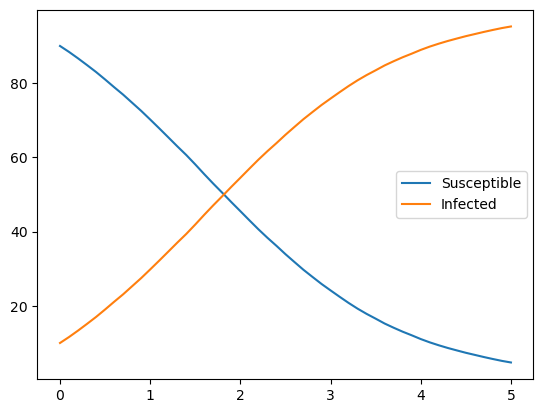

In [4]:
Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)

plt.plot(t_tau, Xs, label='Susceptible')
plt.plot(t_tau, Xi, label='Infected')
plt.legend()

## Mean-field

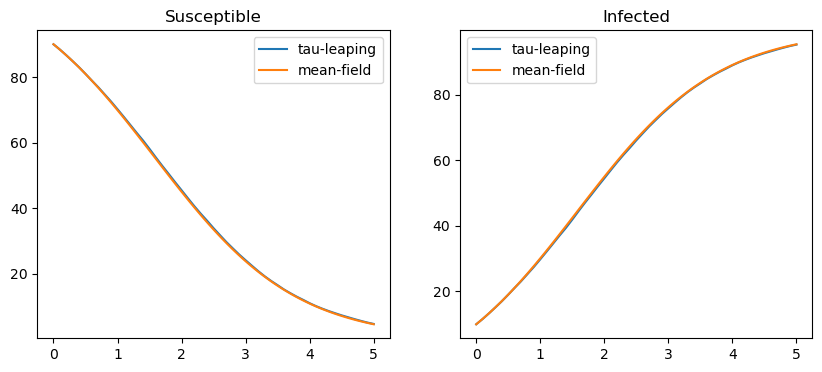

In [5]:
tmf = np.linspace(0,T, 100)
Xmf = mean_field(drift,S_matrix,c,X0,tmf)

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(tmf, Xmf[:,0], label='mean-field')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(tmf, Xmf[:,1], label='mean-field')
axs[1].set_title('Infected')
axs[1].legend()

## SOGA - Gaussian Approximation

In [6]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/SI5.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

C:\Users\birik\github\SOGA4SSA\src\libSOGAupdate.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  pois_it[k_val] = 1 - norm.cdf(-muprime/pois_sigma)
C:\Users\birik\github\SOGA4SSA\src\libSOGAupdate.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  pois_it[k_val] = muprime*pois_it[k_val-1] + pois_sigma*norm.pdf(-muprime/pois_sigma)


Computed in 0.363s


In [7]:
t = len(t_tau)

xs = np.zeros(t)
xi = np.zeros(t)
stds = np.zeros(t)
stdi = np.zeros(t)

for i in range(t):
    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi = output_dist.var_list.index('infected[{}]'.format(i))
    xs[i] = output_dist.gm.mean()[idxs]
    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
    xi[i] = output_dist.gm.mean()[idxi]
    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])

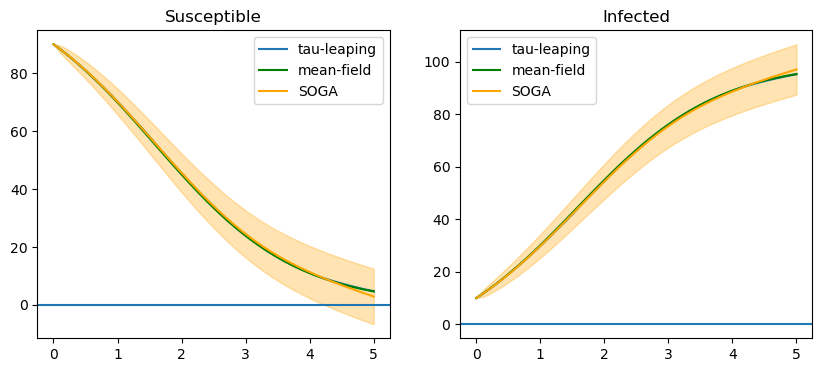

In [8]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color='orange')
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color='orange')
axs[0].set_title('Susceptible')
axs[0].axhline(0)
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color='orange')
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color='orange')
axs[1].set_title('Infected')
axs[1].axhline(0)
axs[1].legend()

## SOGA - Discrete Approximation

In [9]:
# Tau-leaping
S_matrix = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix
c = np.array([0.008, 0.1])  # Reaction rates
X0 = np.array([90, 10])  # Initial state
T = 0.2  # Total time
tau = 0.1  # Leap size

n_runs = 1000
runs = []

for _ in range(n_runs):
    X, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
    
Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)
    
# SOGA

compiledFile=compile2SOGA('../programs/SOGA/SSA/SIdisc.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg, pruning='ranking')
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

t = len(t_tau)
xs = np.zeros(t)
xi = np.zeros(t)
stds = np.zeros(t)
stdi = np.zeros(t)

for i in range(t):
    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi = output_dist.var_list.index('infected[{}]'.format(i))
    xs[i] = output_dist.gm.mean()[idxs]
    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
    xi[i] = output_dist.gm.mean()[idxi]
    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])

Computed in 0.22s


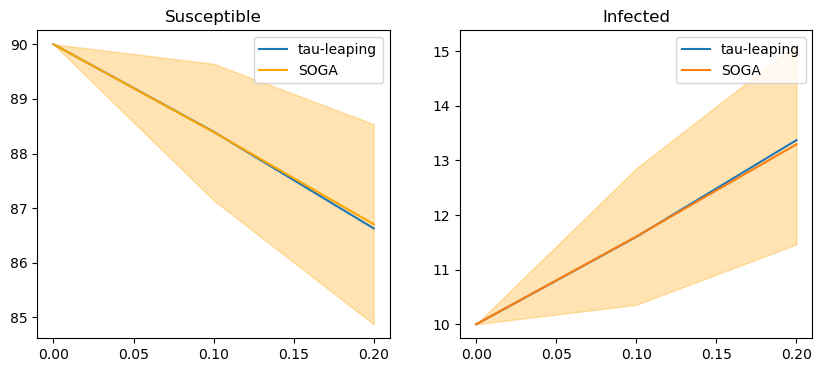

In [10]:
# Plot

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(t_tau, xs, label='SOGA', color='orange')
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color='orange')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(t_tau, xi, label='SOGA')
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color='orange')
axs[1].set_title('Infected')
axs[1].legend()